## Import necessary libraris

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
# Load train dataset
df_train = pd.read_csv('D:/WittingAI/Demand_Forecasting/dataset/train.csv')

In [3]:
# Load test dataset
df_test = pd.read_csv('D:/WittingAI/Demand_Forecasting/dataset/test.csv')

In [4]:
df_train.head(10)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
5,9,17/01/11,8091,219009,227.2875,227.2875,0,0,18
6,10,17/01/11,8091,219029,327.0375,327.0375,0,0,47
7,13,17/01/11,8091,223245,210.9000,210.9000,0,0,50
8,14,17/01/11,8091,223153,190.2375,234.4125,1,1,82
9,17,17/01/11,8095,216418,99.0375,99.0375,0,0,99


In [5]:
df_train.shape

(150150, 9)

In [6]:
df_train.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold'],
      dtype='object')

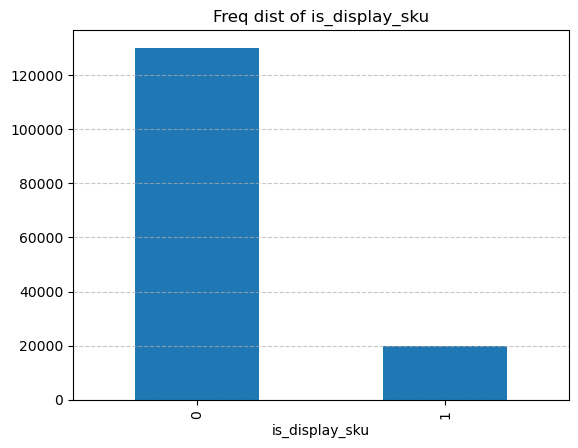

In [7]:
df_train['is_display_sku'].value_counts().plot.bar(title="Freq dist of is_display_sku").grid(axis='y', linestyle='--', alpha=0.7)

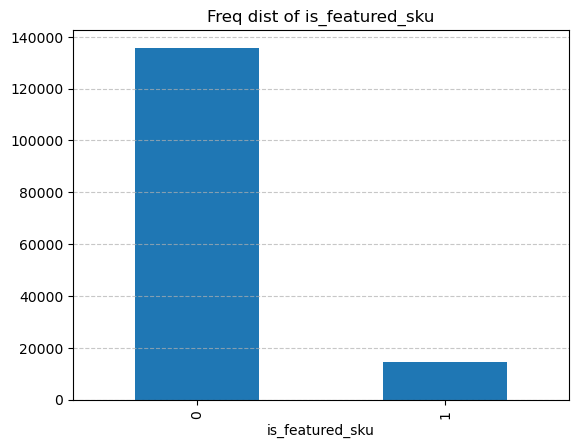

In [8]:
df_train['is_featured_sku'].value_counts().plot.bar(title="Freq dist of is_featured_sku").grid(axis='y', linestyle='--', alpha=0.7)

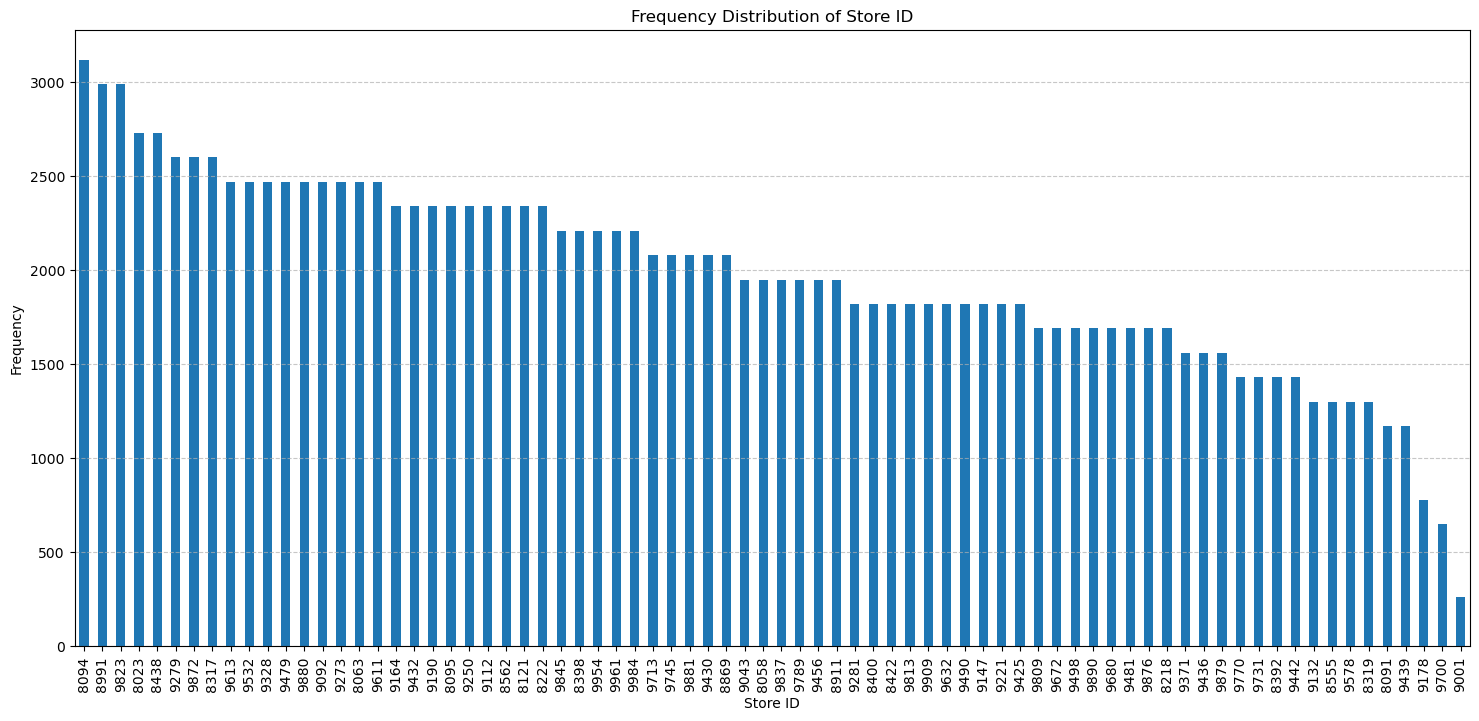

In [9]:
df_train['store_id'].value_counts().plot.bar(title="Frequency Distribution of Store ID", figsize=(18,8))

# Expand Y-axis: Change (0, new_upper_limit) as needed
# plt.ylim(0, df_train['store_id'].value_counts().max() + 100)  # Adds 50 units padding
plt.xlabel("Store ID")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

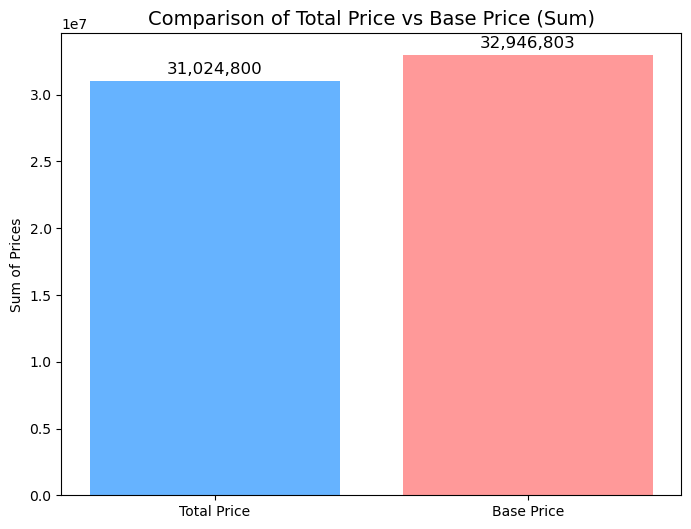

In [10]:
total = df_train['total_price'].sum()
base = df_train['base_price'].sum()

labels = ['Total Price', 'Base Price']
values = [total, base]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, y_val + 0.01 * max(values), f'{y_val:,.0f}', 
             ha='center', va='bottom', fontsize=12)
    
plt.title('Comparison of Total Price vs Base Price (Sum)', fontsize=14)
plt.ylabel('Sum of Prices')
plt.show()

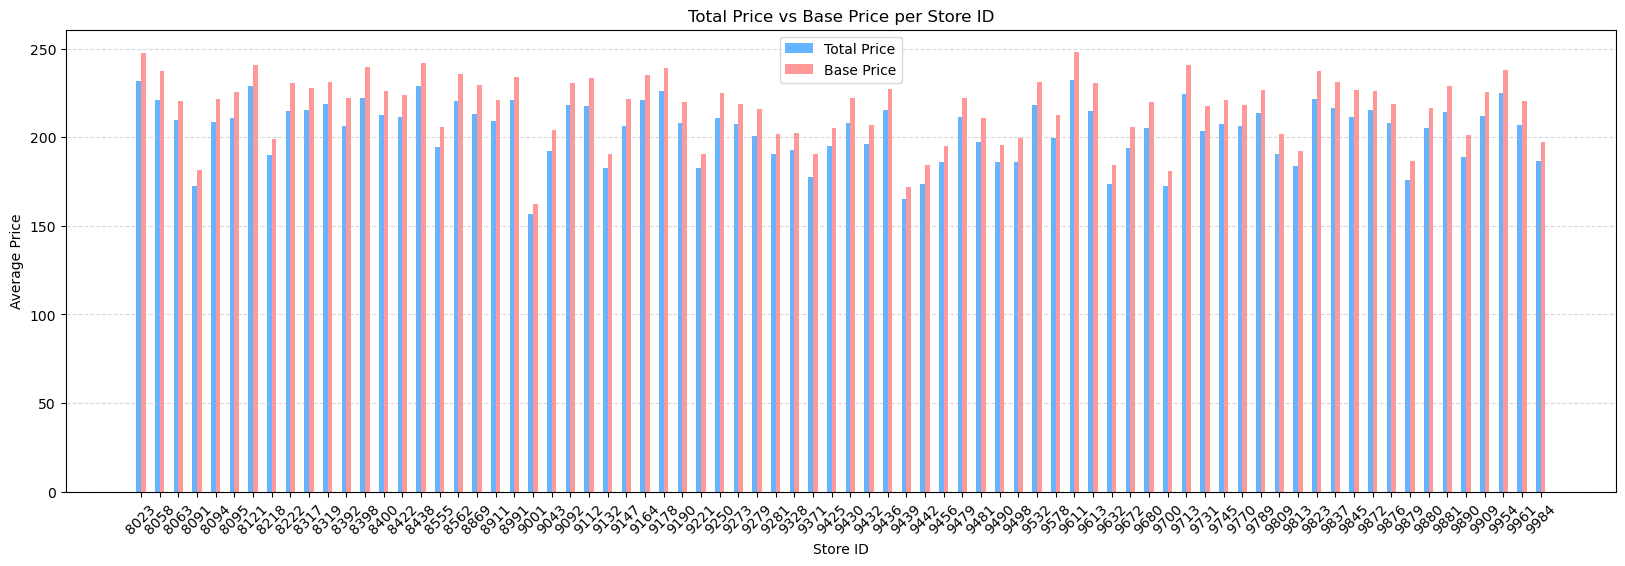

In [11]:
# Group by store_id and calculate average or total price
store_prices = df_train.groupby('store_id')[['total_price', 'base_price']].mean().reset_index()

# Plotting
plt.figure(figsize=(20, 6))
x = store_prices['store_id']
bar_width = 0.25

# Bar positions
r1 = np.arange(len(x))
r2 = [i + bar_width for i in r1]

# Create bars
plt.bar(r1, store_prices['total_price'], width=bar_width, label='Total Price', color='#66b3ff')
plt.bar(r2, store_prices['base_price'], width=bar_width, label='Base Price', color='#ff9999')

# Labeling
plt.xlabel('Store ID')
plt.ylabel('Average Price')
plt.title('Total Price vs Base Price per Store ID')
plt.xticks([r + bar_width / 2 for r in range(len(x))], x, rotation=45)
plt.legend()
# plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

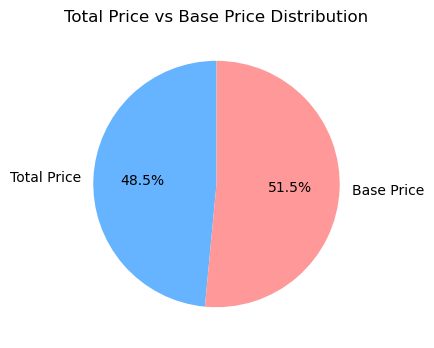

In [12]:
total = df_train['total_price'].sum()
base = df_train['base_price'].sum()

labels = ['Total Price', 'Base Price']
sizes = [total, base]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Total Price vs Base Price Distribution')
plt.show()

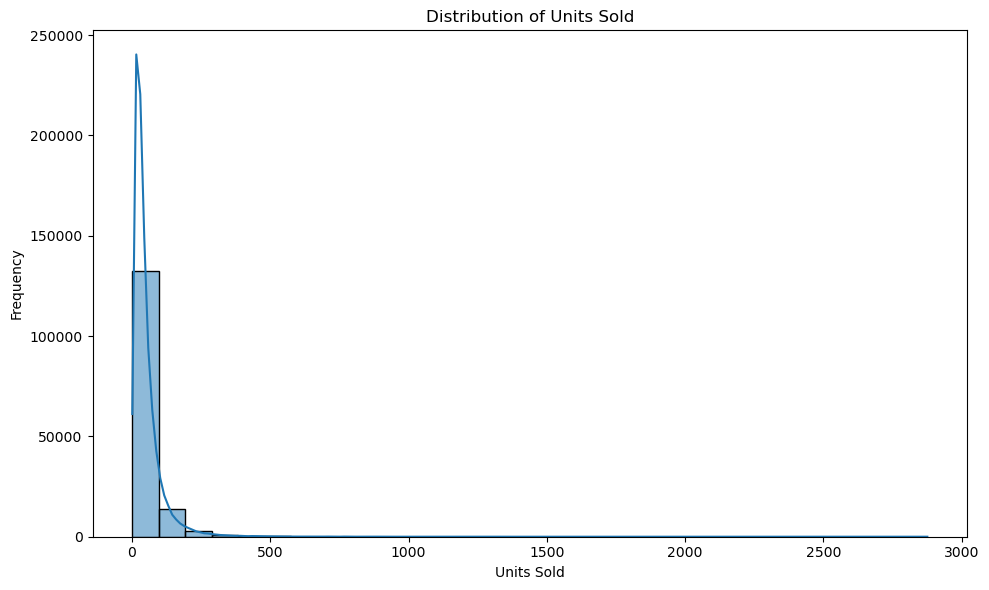

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['units_sold'], kde=True, bins=30)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

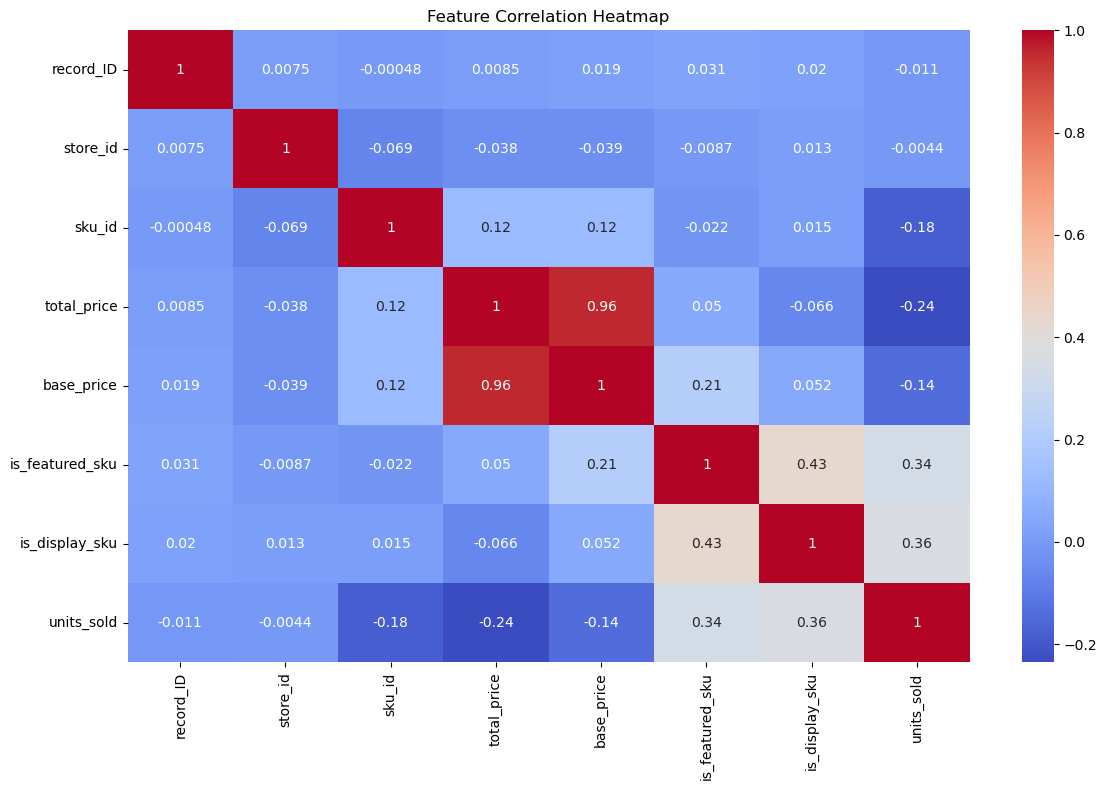

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

Column Name	Description

<i>record_ID:</i>	Unique identifier for each entry in the dataset

<i>week:</i>	Time period (e.g., week number or date) of the record

<i>store_id:</i>	Identifier for the store where the sale happened

<i>sku_id:</i>	Identifier for the product (Stock Keeping Unit(sku))

<i>total_price:</i>	Final selling price after discounts

<i>base_price:</i>	Original price of the product before discounts

<i>is_featured_sku:</i>	1 if the product was part of a marketing, else 0

<i>is_display_sku:</i>	1 if the product was specially displayed (e.g., end cap or homepage), else 0

<i>units_sold:</i>	Number of units sold in that week, store, and SKU combo

In [15]:
df_test.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


In [16]:
df_test.shape

(13860, 8)

In [17]:
df_test.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku'],
      dtype='object')

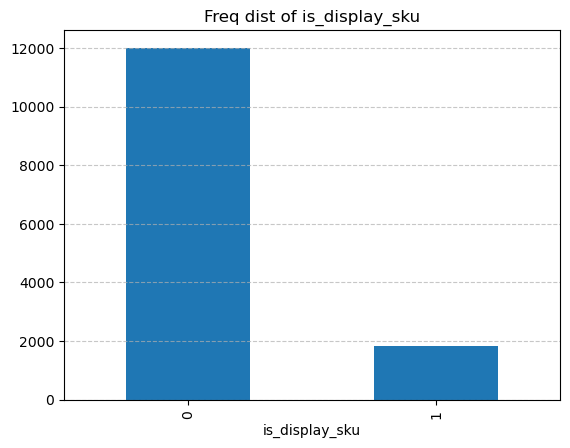

In [18]:
df_test['is_display_sku'].value_counts().plot.bar(title="Freq dist of is_display_sku").grid(axis='y', linestyle='--', alpha=0.7)

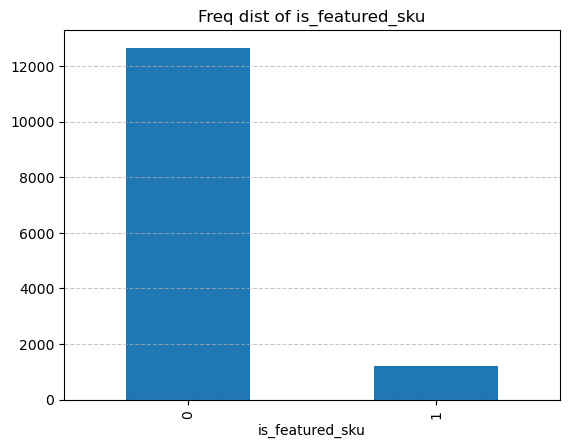

In [19]:
df_test['is_featured_sku'].value_counts().plot.bar(title="Freq dist of is_featured_sku").grid(axis='y', linestyle='--', alpha=0.7)

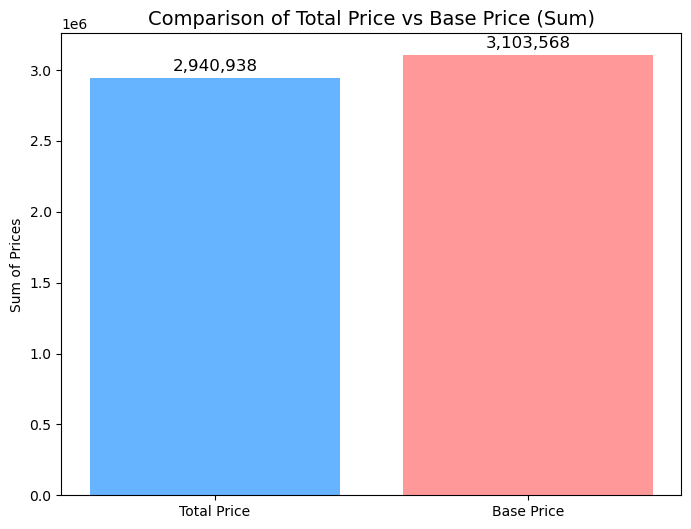

In [20]:
total = df_test['total_price'].sum()
base = df_test['base_price'].sum()

labels = ['Total Price', 'Base Price']
values = [total, base]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)

for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, y_val + 0.01 * max(values), f'{y_val:,.0f}', 
             ha='center', va='bottom', fontsize=12)
    
plt.title('Comparison of Total Price vs Base Price (Sum)', fontsize=14)
plt.ylabel('Sum of Prices')
plt.show()

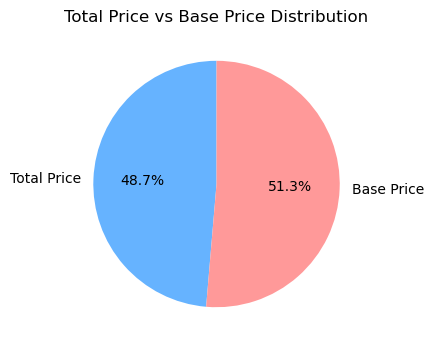

In [21]:
total = df_test['total_price'].sum()
base = df_test['base_price'].sum()

labels = ['Total Price', 'Base Price']
sizes = [total, base]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Total Price vs Base Price Distribution')
plt.show()

## Data Cleaning

In [22]:
df_train['source'] = 'train'
df_test['source'] = 'test'

In [23]:
# combine the train and test dataset to clean uniformly
df_combined = pd.concat([df_train, df_test], ignore_index=True)

In [24]:
df_combined.drop_duplicates(inplace=True)  # Remove duplicates

In [25]:
# Convert date column
if 'week' in df_combined.columns:
    try:
        df_combined['week'] = pd.to_datetime(df_combined['week'], errors='coerce')
    except:
        pass

In [26]:
df_combined = df_combined[df_combined['week'].notnull()].copy()

In [27]:
for col in df_combined.columns:
    if df_combined[col].dtype == 'object':
        df_combined[col].fillna(df_combined[col].mode()[0], inplace=True)
    else:
        df_combined[col].fillna(df_combined[col].mean(), inplace=True)

## Feature Engineering

In [28]:
encoder = LabelEncoder()

def encode(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()

    df['week_encoded'] = encoder.fit_transform(df['week'])

    # Create store-sku combined label
    df['store_sku'] = encoder.fit_transform(df['store_id'].astype(str) + '_' + df['sku_id'].astype(str))

    # Price difference
    df['price_diff'] = df['base_price'] - df['total_price']

    # Price ratio (not divide by zero)
    df['price_ratio'] = df['total_price'] / (df['base_price'] + 1e-5)

    # Interaction feature
    df['interaction'] = df['is_featured_sku'] * df['is_display_sku']

    return df

In [29]:
df_combined_encoded = encode(df_combined)

In [30]:
df_train_cleaned = df_combined[df_combined['source'] == 'train'].drop(columns=['source'])
df_test_cleaned = df_combined[df_combined['source'] == 'test'].drop(columns=['source'])

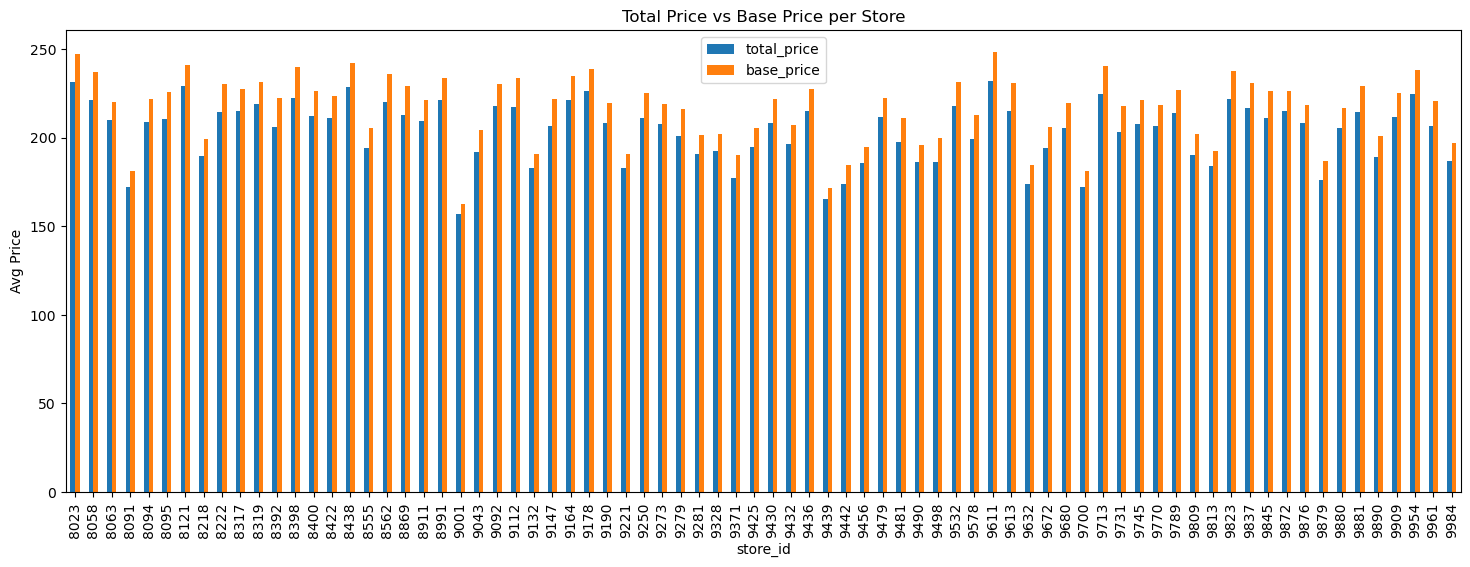

In [31]:
store_prices = df_train_cleaned.groupby('store_id')[['total_price', 'base_price']].mean().reset_index()
store_prices.plot(x='store_id', kind='bar', figsize=(18, 6))
plt.title('Total Price vs Base Price per Store')
plt.ylabel('Avg Price')
plt.xticks(rotation=90)
plt.show()

In [32]:
encode(df_train_cleaned)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_encoded,store_sku,price_diff,price_ratio,interaction
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20.0,1,56,12.8250,0.885350,0
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28.0,1,57,0.0000,1.000000,0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19.0,1,58,0.0000,1.000000,0
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44.0,1,55,0.0000,1.000000,0
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52.0,1,59,0.0000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38.0,126,1148,0.0000,1.000000,0
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30.0,126,1147,0.0000,1.000000,0
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31.0,126,1149,126.1125,0.739323,1
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12.0,126,1153,49.8750,0.739777,0


In [33]:
encode(df_test_cleaned)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,week_encoded,store_sku,price_diff,price_ratio,interaction
150150,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0,51.674206,3,56,0.0000,1.000000,0
150151,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0,51.674206,3,57,0.0000,1.000000,0
150152,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0,51.674206,3,58,0.0000,1.000000,0
150153,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0,51.674206,3,55,0.0000,1.000000,0
150154,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0,51.674206,3,59,0.0000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164005,232281,2013-01-10,9984,223245,241.5375,241.5375,0,0,51.674206,0,1148,0.0000,1.000000,0
164006,232282,2013-01-10,9984,223153,240.8250,240.8250,0,0,51.674206,0,1147,0.0000,1.000000,0
164007,232285,2013-01-10,9984,245338,382.6125,401.8500,1,1,51.674206,0,1149,19.2375,0.952128,1
164008,232286,2013-01-10,9984,547934,191.6625,191.6625,0,0,51.674206,0,1153,0.0000,1.000000,0


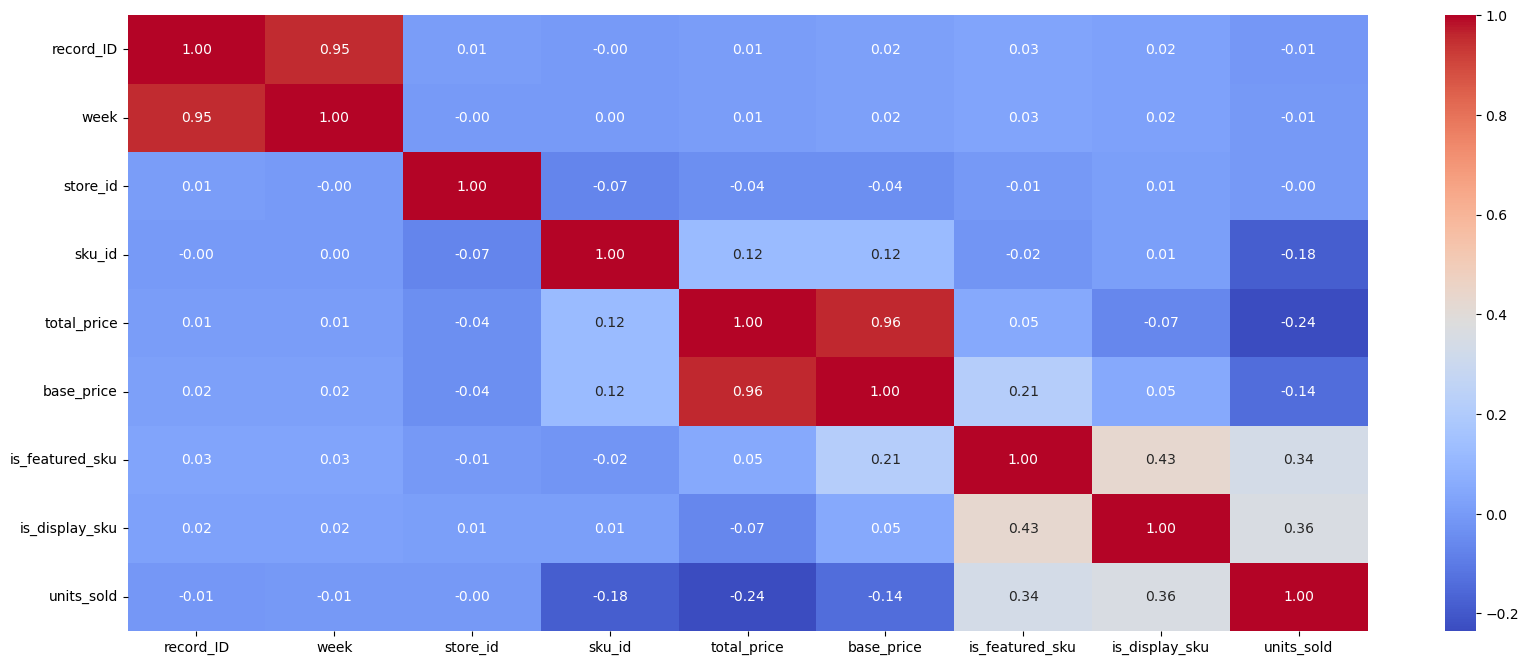

In [34]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df_train_cleaned.corr(),annot=True,cmap='coolwarm', fmt=".2f")

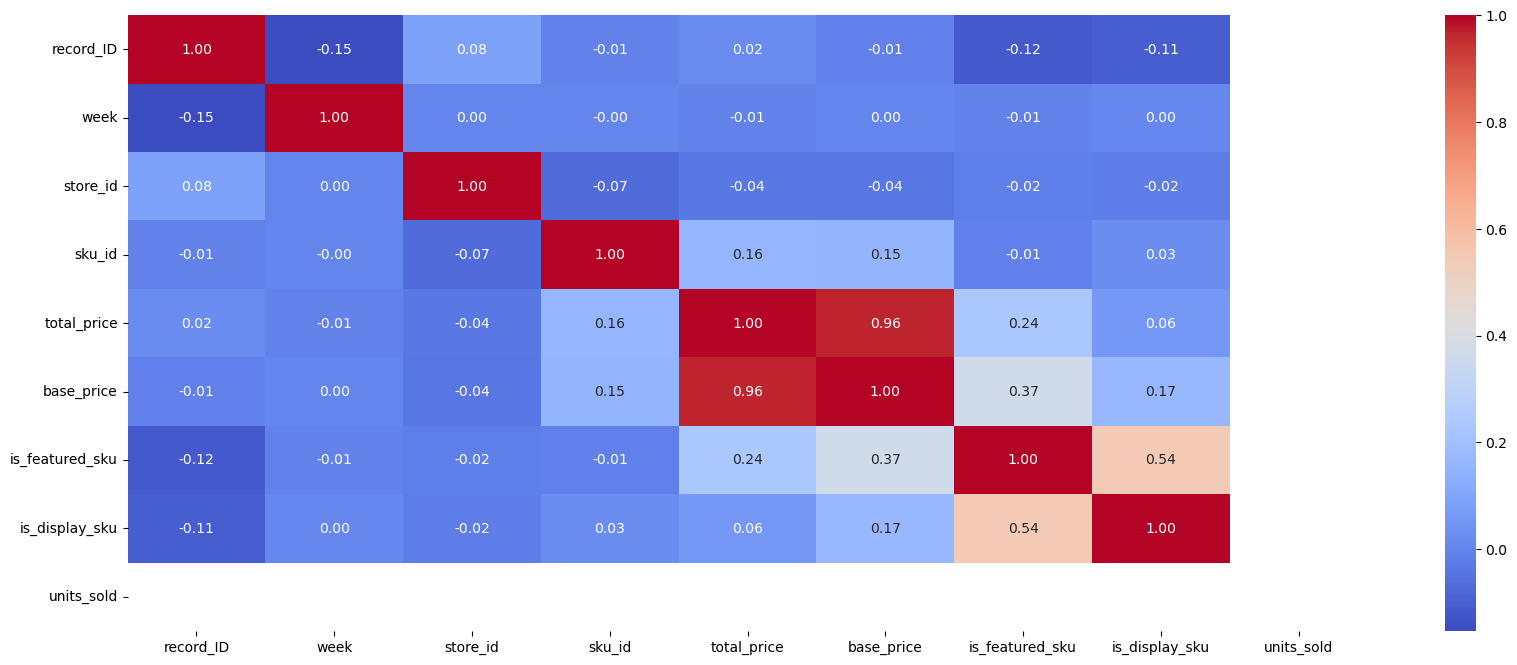

In [35]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df_test_cleaned.corr(),annot=True,cmap='coolwarm', fmt=".2f")

In [36]:
X = df_train_cleaned.drop(columns=["units_sold"], inplace=False)
y = df_train_cleaned["units_sold"]

In [37]:
X = X.drop(columns=['week'])

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
x_train.shape

(120120, 7)

In [41]:
x_test.shape

(30030, 7)

In [42]:
y_train.shape

(120120,)

In [43]:
y_test.shape

(30030,)

In [44]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42)
}

results = {}

In [45]:
from sklearn.metrics import mean_absolute_percentage_error

In [46]:
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Regression metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'MAPE': mape * 100  # Percentage
    }

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 120120, number of used features: 7
[LightGBM] [Info] Start training from score 51.789352


In [47]:
for model_name, metrics in results.items():
    print(f"\n {model_name} Performance:")
    for metric_name, value in metrics.items():
        if metric_name == "MAPE":
            print(f"{metric_name}: {value:.2f}%")
        else:
            print(f"{metric_name}: {value:.4f}")


 Linear Regression Performance:
MAE: 30.1239
MSE: 2399.4640
RMSE: 48.9843
R2 Score: 0.2687
MAPE: 114.50%

 Random Forest Performance:
MAE: 13.8198
MSE: 726.9793
RMSE: 26.9626
R2 Score: 0.7784
MAPE: 41.29%

 XGBoost Performance:
MAE: 13.8501
MSE: 581.0133
RMSE: 24.1042
R2 Score: 0.8229
MAPE: 44.61%

 LightGBM Performance:
MAE: 16.6852
MSE: 759.0952
RMSE: 27.5517
R2 Score: 0.7686
MAPE: 60.25%


<Figure size 600x400 with 0 Axes>

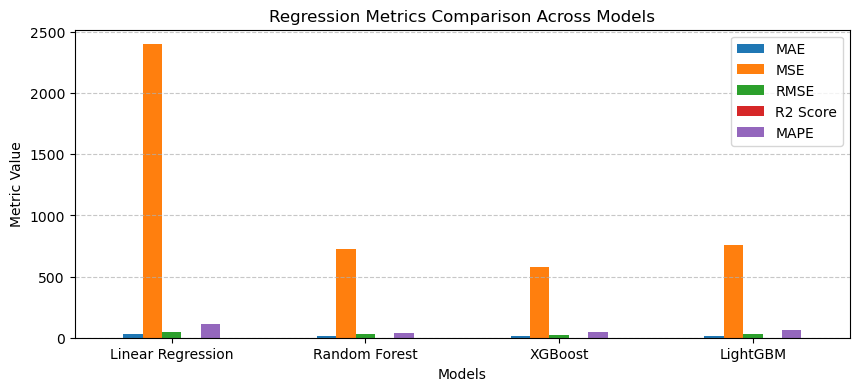

In [48]:
results_df = pd.DataFrame(results).T  

plt.figure(figsize=(6, 4))
results_df.plot(kind='bar', figsize=(10, 4))
plt.title('Regression Metrics Comparison Across Models')
plt.ylabel('Metric Value')
plt.xlabel('Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

In [49]:
print("Mean Absolute Error for each model: \n", results_df['MAE'])

Mean Absolute Error for each model: 
 Linear Regression    30.123906
Random Forest        13.819810
XGBoost              13.850130
LightGBM             16.685206
Name: MAE, dtype: float64


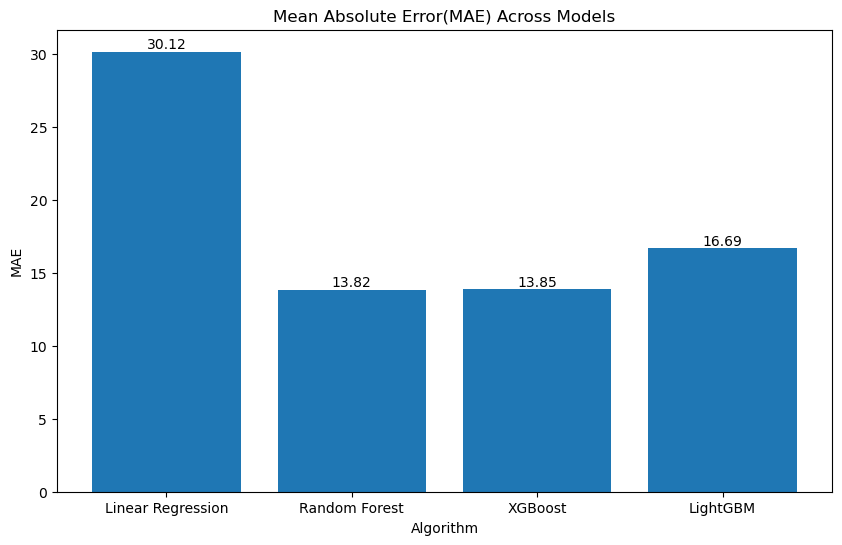

In [50]:
FinalResult_MAE = pd.DataFrame({'Algorithm': results_df.index, 'MAE': results_df['MAE']})

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(FinalResult_MAE['Algorithm'], FinalResult_MAE['MAE'], color='tab:blue')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Mean Absolute Error(MAE) Across Models')
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.xticks(rotation=0)
plt.show()

In [51]:
print("Mean Squared Error for each model: \n", results_df['MSE'])

Mean Squared Error for each model: 
 Linear Regression    2399.463951
Random Forest         726.979288
XGBoost               581.013293
LightGBM              759.095153
Name: MSE, dtype: float64


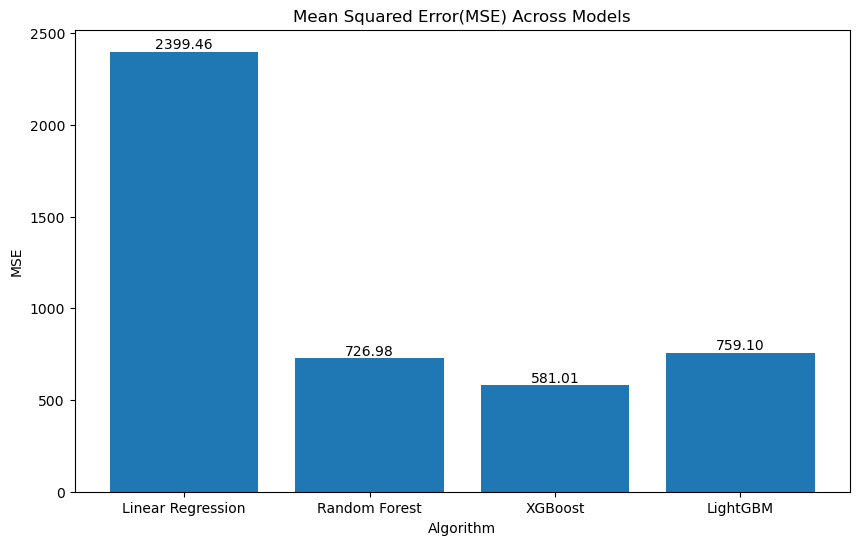

In [52]:
FinalResult_MSE = pd.DataFrame({'Algorithm': results_df.index, 'MSE': results_df['MSE']})

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(FinalResult_MSE['Algorithm'], FinalResult_MSE['MSE'], color='tab:blue')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Mean Squared Error(MSE) Across Models')
plt.xlabel('Algorithm')
plt.ylabel('MSE')
plt.xticks(rotation=0)
plt.show()

In [53]:
print("Root Mean Squared Error for each model: \n", results_df['RMSE'])

Root Mean Squared Error for each model: 
 Linear Regression    48.984324
Random Forest        26.962553
XGBoost              24.104217
LightGBM             27.551681
Name: RMSE, dtype: float64


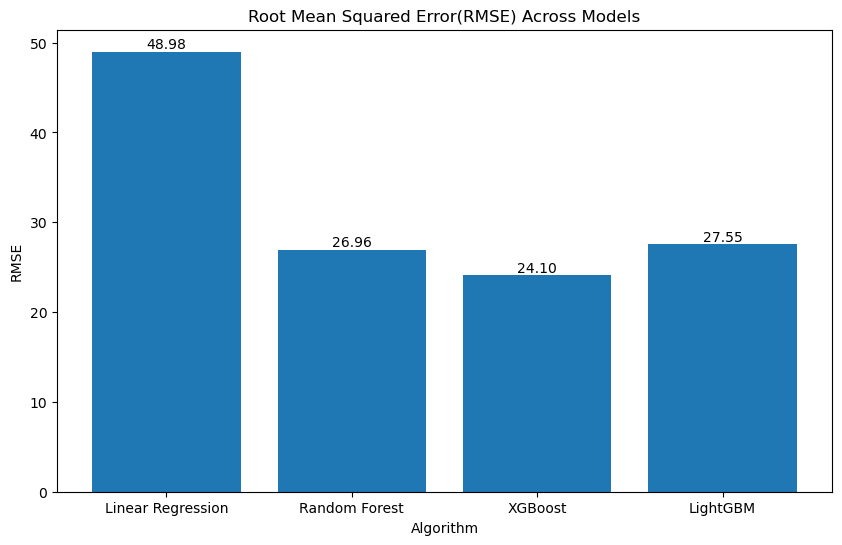

In [54]:
FinalResult_RMSE = pd.DataFrame({'Algorithm': results_df.index, 'RMSE': results_df['RMSE']})

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(FinalResult_RMSE['Algorithm'], FinalResult_RMSE['RMSE'], color='tab:blue')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Root Mean Squared Error(RMSE) Across Models')
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()

In [55]:
print("R2 Score for each model: \n", results_df['R2 Score'])

R2 Score for each model: 
 Linear Regression    0.268707
Random Forest        0.778436
XGBoost              0.822923
LightGBM             0.768648
Name: R2 Score, dtype: float64


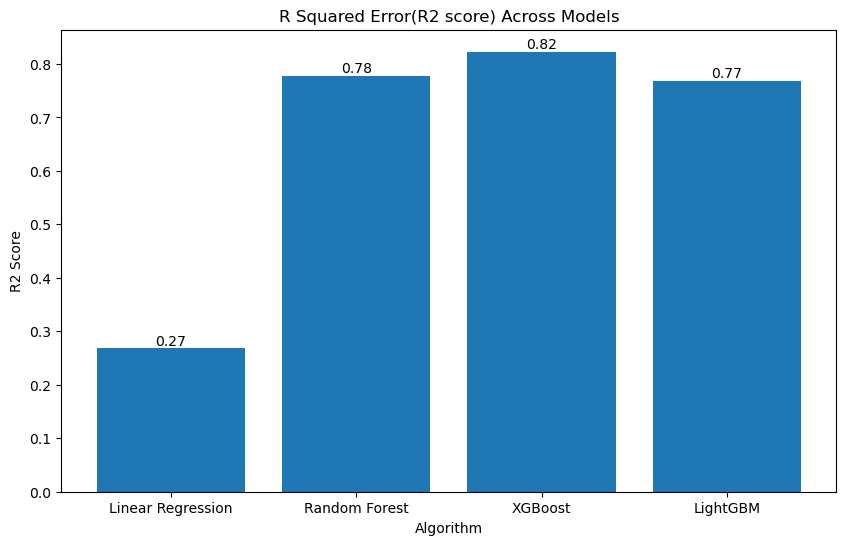

In [56]:
FinalResult_R2_SCORE = pd.DataFrame({'Algorithm': results_df.index, 'R2 Score': results_df['R2 Score']})

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(FinalResult_R2_SCORE['Algorithm'], FinalResult_R2_SCORE['R2 Score'], color='tab:blue')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('R Squared Error(R2 score) Across Models')
plt.xlabel('Algorithm')
plt.ylabel('R2 Score')
plt.xticks(rotation=0)
plt.show()

In [57]:
print("Mean Absolute Percentage Error Score for each model: \n", results_df['MAPE'])

Mean Absolute Percentage Error Score for each model: 
 Linear Regression    114.496357
Random Forest         41.293625
XGBoost               44.606139
LightGBM              60.247875
Name: MAPE, dtype: float64


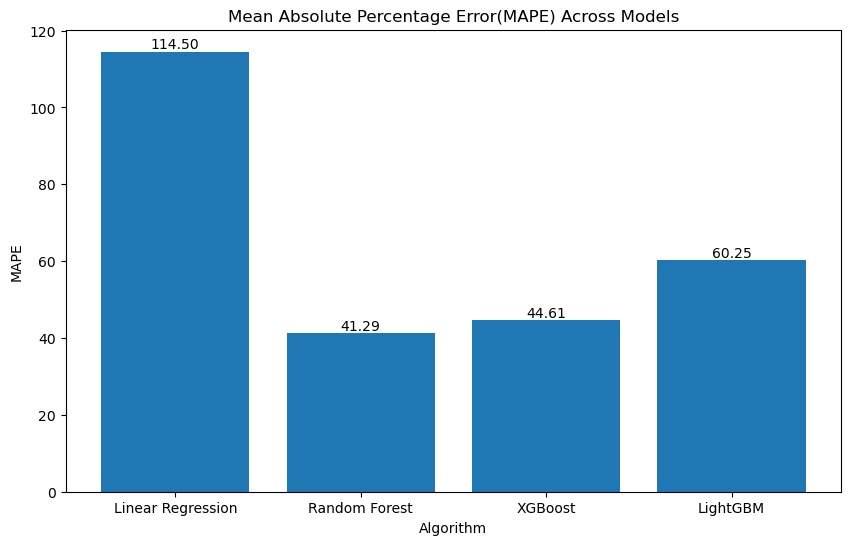

In [58]:
FinalResult_MAPE = pd.DataFrame({'Algorithm': results_df.index, 'MAPE': results_df['MAPE']})

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(FinalResult_MAPE['Algorithm'], FinalResult_MAPE['MAPE'], color='tab:blue')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Mean Absolute Percentage Error(MAPE) Across Models')
plt.xlabel('Algorithm')
plt.ylabel('MAPE')
plt.xticks(rotation=0)
plt.show()

In [59]:
best_models = {
    'Lowest MAE': results_df['MAE'].idxmin(),
    'Lowest MSE': results_df['MSE'].idxmin(),
    'Lowest RMSE': results_df['RMSE'].idxmin(),
    'Lowest MAPE (%)': results_df['MAPE'].idxmin(),
    'Highest R² Score': results_df['R2 Score'].idxmax()
}

for metric, model in best_models.items():
    value = results_df.loc[model, metric.split()[1] if 'R²' not in metric else 'R2 Score']
    print(f"{metric}: {model} : {value:.4f}")

Lowest MAE: Random Forest : 13.8198
Lowest MSE: XGBoost : 581.0133
Lowest RMSE: XGBoost : 24.1042
Lowest MAPE (%): Random Forest : 41.2936
Highest R² Score: XGBoost : 0.8229


In [60]:
from autogluon.tabular import TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df_train = pd.read_csv('D:/WittingAI/Demand_Forecasting/dataset/train.csv')
df_test = pd.read_csv('D:/WittingAI/Demand_Forecasting/dataset/test.csv')

target = 'units_sold'

df_train = df_train.dropna(subset=[target])

train_data, val_data = train_test_split(df_train, test_size=0.2, random_state=42)

predictor = TabularPredictor(label=target, eval_metric='root_mean_squared_error', problem_type='regression').fit(
    train_data=train_data,
    presets='best_quality',
    time_limit=600
)

# Predictions on validation data
val_preds = predictor.predict(val_data)

# Evaluate the model
results = predictor.evaluate(val_data)
print("Performance Metrics:", results)

# Calculate custom metrics
mse = mean_squared_error(val_data[target], val_preds)
mae = mean_absolute_error(val_data[target], val_preds)
r2 = r2_score(val_data[target], val_preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(val_data[target], val_preds)
print(f"Custom Metrics:\nMSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}, RMSE: {rmse:.4f}, MAPE: {mape * 100:.2f}%")

# Predictions on test data
test_preds = predictor.predict(df_test)
print(test_preds.head())

No path specified. Models will be saved in: "AutogluonModels\ag-20250406_113333"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          16
Memory Avail:       4.02 GB / 15.42 GB (26.1%)
Disk Space Avail:   18.77 GB / 175.78 GB (10.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout v

(_ray_fit pid=24324) [1000]	valid_set's rmse: 32.3443
(_ray_fit pid=24528) [2000]	valid_set's rmse: 30.7891 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=24324) [3000]	valid_set's rmse: 28.5846 [repeated 8x across cluster]
(_ray_fit pid=24324) [4000]	valid_set's rmse: 27.7225 [repeated 8x across cluster]
(_ray_fit pid=24324) [5000]	valid_set's rmse: 27.1263 [repeated 8x across cluster]


(_ray_fit pid=24324) 	Ran out of time, early stopping on iteration 5374. Best iteration is:
(_ray_fit pid=24324) 	[5373]	valid_set's rmse: 26.9369
(_dystack pid=8100) 	-28.8235	 = Validation score   (-root_mean_squared_error)
(_dystack pid=8100) 	74.64s	 = Training   runtime
(_dystack pid=8100) 	170.98s	 = Validation runtime
(_ray_fit pid=24376) 	Ran out of time, early stopping on iteration 5288. Best iteration is: [repeated 7x across cluster]
(_ray_fit pid=24376) 	[5288]	valid_set's rmse: 27.0126 [repeated 7x across cluster]
(_dystack pid=8100) Fitting model: WeightedEnsemble_L2 ... Training model for up to 140.28s of the 30.27s of remaining time.
(_dystack pid=8100) 	Ensemble Weights: {'LightGBMXT_BAG_L1': 1.0}
(_dystack pid=8100) 	-28.8235	 = Validation score   (-root_mean_squared_error)
(_dystack pid=8100) 	0.17s	 = Training   runtime
(_dystack pid=8100) 	0.0s	 = Validation runtime
(_dystack pid=8100) Fitting 106 L2 models, fit_strategy="sequential" ...
(_dystack pid=8100) Fitting 

(_ray_fit pid=23548) [1000]	valid_set's rmse: 29.1545 [repeated 8x across cluster]


(_ray_fit pid=21852) 	Ran out of time, early stopping on iteration 1808. Best iteration is:
(_ray_fit pid=21852) 	[1791]	valid_set's rmse: 29.6865
(_ray_fit pid=23548) 	Ran out of time, early stopping on iteration 1922. Best iteration is:
(_ray_fit pid=23548) 	[1763]	valid_set's rmse: 28.9934
(_dystack pid=8100) 	-29.0427	 = Validation score   (-root_mean_squared_error)
(_dystack pid=8100) 	26.5s	 = Training   runtime
(_dystack pid=8100) 	45.74s	 = Validation runtime
(_ray_fit pid=8536) 	Ran out of time, early stopping on iteration 1788. Best iteration is: [repeated 5x across cluster]
(_ray_fit pid=8536) 	[1788]	valid_set's rmse: 28.6922 [repeated 5x across cluster]
(_dystack pid=8100) Fitting model: WeightedEnsemble_L3 ... Training model for up to 140.28s of the -9.55s of remaining time.
(_dystack pid=8100) 	Ensemble Weights: {'LightGBMXT_BAG_L1': 0.56, 'LightGBMXT_BAG_L2': 0.44}
(_dystack pid=8100) 	-28.4748	 = Validation score   (-root_mean_squared_error)
(_dystack pid=8100) 	0.16s	

Performance Metrics: {'root_mean_squared_error': -21.095821772876715, 'mean_squared_error': -445.0336962729792, 'mean_absolute_error': -12.161769092672474, 'r2': 0.8643655776977539, 'pearsonr': 0.9297577963338255, 'median_absolute_error': -7.881166458129883}
Custom Metrics:
MSE: 445.0337, MAE: 12.1618, R^2: 0.8644, RMSE: 21.0958, MAPE: 39.67%
0    46.594521
1    22.908489
2    23.115084
3    26.354889
4    24.700680
Name: units_sold, dtype: float32


In [61]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-23.792963,root_mean_squared_error,662.764841,321.956762,0.002992,0.226629,3,True,7
1,LightGBM_BAG_L1,-23.960246,root_mean_squared_error,43.884409,28.067425,43.884409,28.067425,1,True,4
2,WeightedEnsemble_L2,-23.960246,root_mean_squared_error,43.887398,28.291764,0.002988,0.224339,2,True,5
3,LightGBMXT_BAG_L2,-25.474771,root_mean_squared_error,662.761849,321.730133,191.174335,108.653749,2,True,6
4,LightGBMXT_BAG_L1,-26.903241,root_mean_squared_error,425.990066,183.917639,425.990066,183.917639,1,True,3
5,KNeighborsDist_BAG_L1,-46.703550,root_mean_squared_error,0.824671,0.550102,0.824671,0.550102,1,True,2
6,KNeighborsUnif_BAG_L1,-47.887514,root_mean_squared_error,0.888368,0.541216,0.888368,0.541216,1,True,1


In [63]:
print("Custom Regression Metrics: \n")
print(f"Autogluon MAE (Mean Absolute Error): {mae:.4f}")
print(f"Autogluon MSE (Mean Squared Error): {mse:.4f}")
print(f"Autogluon R2 Score (R-squared Score): {r2:.4f}")
print(f"Autogluon RMSE(Root Mean Squared Error): {rmse:.4f}")
print(f"Autogluon MAPE(Mean Absolute Percentage Error): {mape * 100:.2f}%")

Custom Regression Metrics: 

Autogluon MAE (Mean Absolute Error): 12.1618
Autogluon MSE (Mean Squared Error): 445.0337
Autogluon R2 Score (R-squared Score): 0.8644
Autogluon RMSE(Root Mean Squared Error): 21.0958
Autogluon MAPE(Mean Absolute Percentage Error): 39.67%


In [66]:
best_models = {
    'Lowest MAE': results_df['MAE'].idxmin(),
    'Lowest MSE': results_df['MSE'].idxmin(),
    'Lowest RMSE': results_df['RMSE'].idxmin(),
    'Lowest MAPE (%)': results_df['MAPE'].idxmin(),
    'Highest R² Score': results_df['R2 Score'].idxmax()
}

for metric, model in best_models.items():
    value = results_df.loc[model, metric.split()[1] if 'R²' not in metric else 'R2 Score']
    print(f"{metric}: {model} : {value:.4f}")

Lowest MAE: Random Forest : 13.8198
Lowest MSE: XGBoost : 581.0133
Lowest RMSE: XGBoost : 24.1042
Lowest MAPE (%): Random Forest : 41.2936
Highest R² Score: XGBoost : 0.8229


MAE(Mean Absolute Error): Average of absolute errors. Less sensitive to outliers.	0 to ∞. Lower is better

MSE(Mean Squared Error): Average of squared errors. Penalizes large errors more.	0 to ∞.	Lower is better

RMSE(Root Mean Squared Error): Square root of MSE. Interpretable in same unit as target.	0 to ∞.	Lower is better

R² Score(Coefficient of Determination): % of variance in target explained by model.	−∞ to 1.	Closer to 1 is better

MAPE(Mean Absolute Percentage Error): Mean error as a percentage of actual value.	0% to ∞%.	Lower is better